In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
from Bio import AlignIO
import time as time
import pandas as pd

In [2]:
starttime = time.time()

#Open data from h5py

data_path = '../../../data_RFAM/riboswitch_100k_d4.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 9.72s


In [3]:
simalign_file = '../../../data_RFAM/riboswitch_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

bpSS

'(((((<<<<<<>>>>>><<<<<<<<<>>>>>>>>>)))))<<<<>>>>'

In [4]:
ugSS

':::::(((((,,,,<-<<<<<____>>>>>><<<--<<<<<<______>>>->>>->>>,,,,,)))))-<<<<____>>>>::::::::::::::::'

In [5]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/riboswitch'
param_path = os.path.join(save_path, 'resbind_t4')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 816, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: den

In [6]:
# initialize session
sess = utils.initialize_session()

In [7]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=30, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=13.87s -- loss=0.34444 -- acc=82.15750%  
 
  valid loss:		0.06965
  valid accuracy:	0.97780+/-0.00000
  valid auc-roc:	0.99738+/-0.00000
  valid auc-pr:		0.99712+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/riboswitch/resbind_t4_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=13.42s -- loss=0.07601 -- acc=97.53584%  
 
  valid loss:		0.03253
  valid accuracy:	0.99235+/-0.00000
  valid auc-roc:	0.99942+/-0.00000
  valid auc-pr:		0.99909+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/riboswitch/resbind_t4_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=13.36s -- loss=0.04812 -- acc=98.64500%  
 
  valid loss:		0.02627
  valid accuracy:	0.99445+/-0.00000
  valid auc-roc:	0.99984+/-0.00000
  valid auc-pr:		0.99984+/-0.00000
  lower cross-validation found
  saving model to:  ..

In [8]:
# initialize session
sess.close()
sess = utils.initialize_session()

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/riboswitch/resbind_t4_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/riboswitch/resbind_t4_best.ckpt
  test  loss:		0.02209
  test  accuracy:	0.99618+/-0.00000
  test  auc-roc:	0.99992+/-0.00000
  test  auc-pr:		0.99991+/-0.00000


/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


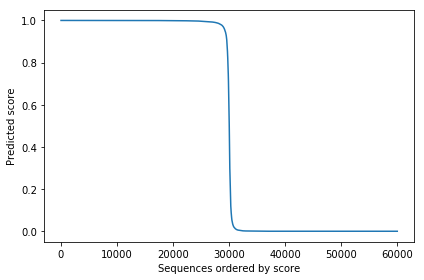

In [8]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

plt.figure()
plt.ylabel('Predicted score')
plt.xlabel('Sequences ordered by score')
plt.plot(range(len(plot_index)), predictionsoutput[plot_index])

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


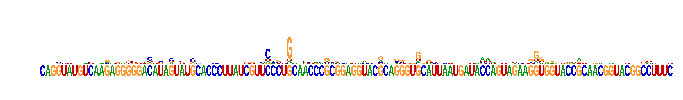

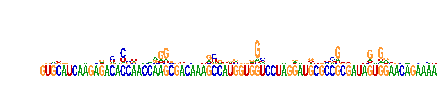

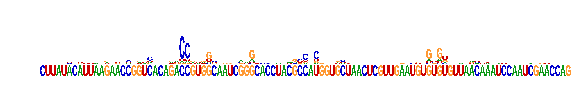

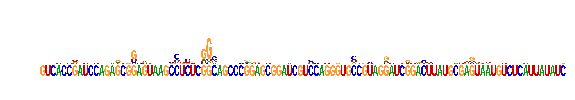

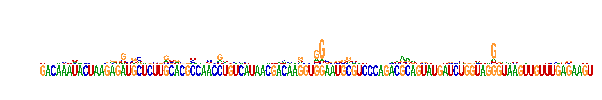

In [11]:
num_plots=np.linspace(0,20000,5).astype(int)
#num_plots = range(5)
for ii in num_plots: 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))

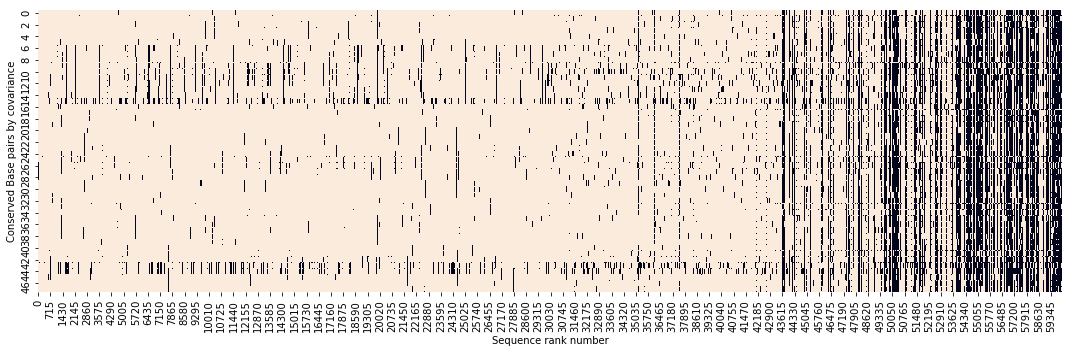

In [12]:
#num_plots=np.linspace(0,10000,10).astype(int)
num_plots = range(int(numdata*test_frac))
#for sp, ii in enumerate(num_plots): 
    
def nucpresence(Xdict, ii):
    X = np.expand_dims(Xdict['inputs'][plot_index[ii]], axis=0)
    nuc_index = np.where(np.sum(X, axis=0)!=0)[0]
    nucpos = np.zeros(shape=(1,seqlen))
    nucpos[:, nuc_index] = 1.
    return nucpos

nuc_sequences = [nucpresence(test,ii) for ii in num_plots]
    
plt.figure(figsize=(15,5))
sb.heatmap(np.squeeze(nuc_sequences)[:, bpidx].T, cbar=False)
plt.ylabel('Conserved Base pairs by covariance')
plt.xlabel('Sequence rank number')


In [13]:
savepath = 'Arrays/riboswitch_resbindt4_ug_so1k.npy'

num_summary = 1000
Xdict = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=ugidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='on', save=True, layer='dense_1_bias', 
                               normalize=False, normfactor=0)

0
Epoch duration =5.27s
Cumulative duration =5.27s

1
Epoch duration =5.28s
Cumulative duration =10.55s

2
Epoch duration =5.24s
Cumulative duration =15.79s

3
Epoch duration =5.25s
Cumulative duration =21.04s

4
Epoch duration =5.25s
Cumulative duration =26.3s

5
Epoch duration =5.21s
Cumulative duration =31.51s

6
Epoch duration =5.21s
Cumulative duration =36.72s

7
Epoch duration =5.22s
Cumulative duration =41.94s

8
Epoch duration =5.24s
Cumulative duration =47.19s

9
Epoch duration =5.23s
Cumulative duration =52.42s

10
Epoch duration =5.26s
Cumulative duration =57.68s

11
Epoch duration =5.24s
Cumulative duration =1min 2.9299999999999997s

12
Epoch duration =5.26s
Cumulative duration =1min 8.189999999999998s

13
Epoch duration =5.29s
Cumulative duration =1min 13.480000000000004s

14
Epoch duration =5.25s
Cumulative duration =1min 18.739999999999995s

15
Epoch duration =5.24s
Cumulative duration =1min 23.980000000000004s

16
Epoch duration =5.24s
Cumulative duration =1min 29.22s



In [9]:
#load values
savepath = 'Arrays/riboswitch_resbindt4_ug_so1k.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1000
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4 matrices
meanhol_mut2 = mean_mut2.reshape(numug,numug,dims,dims)

In [10]:
#normalize the holistic mutation scores
WT_mean = np.mean(nntrainer.get_activations(sess, test, layer='dense_1_bias')[plot_index[:500]])

def normalize_mut_hol(hol_mut, WTmean, nntrainer, sess, normfactor=None):
    norm_hol_mut = np.copy(hol_mut) - WTmean
    for one in range(hol_mut.shape[0]):
        for two in range(hol_mut.shape[0]):
            norm_hol_mut[one, two] = mf.normalize_hol(hol_mut[one, two], factor=normfactor)
    return norm_hol_mut

norm_meanhol_mut2 = normalize_mut_hol(meanhol_mut2, WT_mean, nntrainer, sess)

<function matplotlib.pyplot.show>

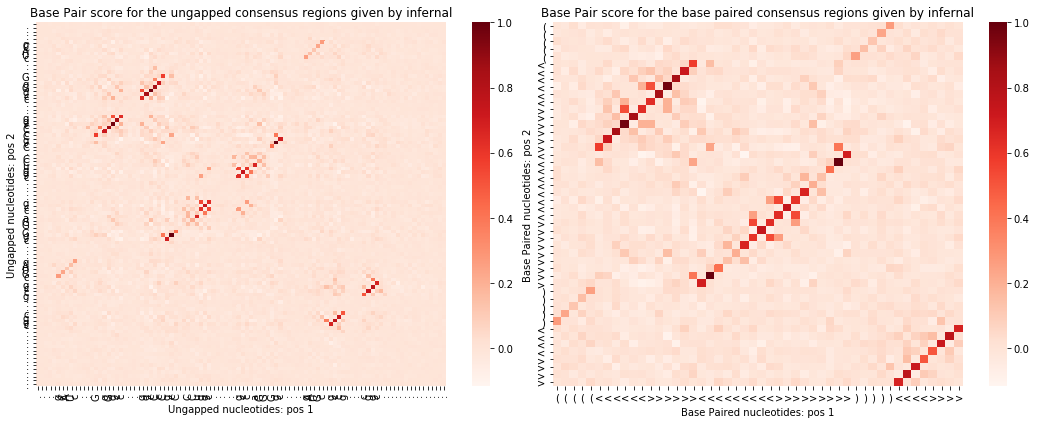

In [11]:
#Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((norm_meanhol_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
C = C - np.mean(C)
C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='Reds', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, cmap='Reds', linewidth=0.0)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show